Importing MobileNetV2

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
model = MobileNetV2(weights='imagenet')

### Data Preprocessing:

Loading the data and generating labels

In [ ]:
import pandas as pd
import numpy as np
from imageio import imread
from skimage.transform import resize
from keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# Read the csv file into the DataFrame
df = pd.read_csv('Labelled_Data.csv')

# Get the number of rows in the DataFrame
num_of_images = len(df)

# Print the number of images
print(f"Number of Labelled Images: {num_of_images}")

In [ ]:
data = np.empty((num_of_images, 224, 224, 3)) #num_of_images is the number of images that I want to train

for i in range(num_of_images):
  image_name = df.iloc[i, 1]
  im = imread(f'Training-Images/{image_name}')
  im = preprocess_input(im)
  im = resize(im, output_shape=(224, 224))
  data[i] = im



Tidy up the data and create the matrix

|Categories | Number Representation |
| --- | --- |
| Cosmetics and Medicine | 0 |
| Electronics | 1 |
| Textile, Clothing & Shoes | 2 |
| Furniture & Home appliances | 3 |
| Toys  | 4 |
| Books & Movies | 5 |


In [ ]:
"""
Generating Labels
"""
category_map = {
    "Cosmetics & Medicine": 0,
    "Electronics": 1,
    "Textile, Clothing & Shoes": 2,
    "Furniture & Home appliances": 3,
    "Toys ": 4,
    "Books & Movies": 5
}


labels = np.empty(num_of_images, dtype=int)

for index, row in df.iterrows():
    category = row[2]
    labels[index] = category_map[category]


Generating predictions for items, without transfer learning

In [ ]:
from keras.applications.mobilenet_v2 import decode_predictions

In [ ]:
predictions = model.predict(data) 

for decoded_prediction in decode_predictions(predictions, top=1):
    for name, desc, score in decoded_prediction:
        print('- {} ({:.2f}%)'.format(desc, 100*score))

Modifying the Model

In [ ]:
from keras.layers import Dense
from keras import Model

In [ ]:
model.summary()

In [ ]:
label_output = Dense(6, activation='softmax')
label_output = label_output(model.layers[-2].output) #this is a keras tensor, to connect the nodes to our putput nodes
label_input = model.input
label_model = Model(inputs=label_input, outputs=label_output)

for layer in label_model.layers[:-1]:
    layer.trainable = False

Compiling the Model

In [ ]:
label_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Training the Model

In [ ]:
label_model.fit(
    x=data,
    y=labels,
    epochs=20,
    verbose=2
)

Generating predictions for training data

In [ ]:
predictions = label_model.predict(data)

In [ ]:
predictions.shape

In [ ]:
np.argmax(predictions, axis=1)

Generating separate training and validation sets

In [ ]:
# separate training and validation sets randomly. 80% training, 20% validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


In [ ]:
label_model.fit(
    x=X_train,
    y=y_train,
    epochs=20,
    verbose=2,
    validation_data=(X_val, y_val)
)

predictions = label_model.predict(X_val)

predictions.shape




In [ ]:
np.argmax(predictions, axis=1)


In [ ]:
# now, check the percentage of accuracy of the model
from sklearn.metrics import accuracy_score

accuracy_score(y_val, np.argmax(predictions, axis=1))


In [ ]:
from sklearn.metrics import f1_score

print("Image Classification using MobileNetV2")

# Print the number of images
print(f"Number of Labelled Images: {num_of_images}")

# Print Summary of the model
label_model.summary()

# Print the accuracy of the model
print(f"Accuracy of the model: {accuracy_score(y_val, np.argmax(predictions, axis=1))}")

# Overview of the results:
print("Overview of the results:")
for i in range(len(predictions)):
    print(f"Image {i+1}: Actual label: {y_val[i]}, Predicted label: {np.argmax(predictions[i])}")


# Print the f-measure of the model
print(f"F-measure of the model: {f1_score(y_val, np.argmax(predictions, axis=1), average='macro')}")

# Print the confusion matrix of the model
from sklearn.metrics import confusion_matrix
print(f"Confusion Matrix of the model: {confusion_matrix(y_val, np.argmax(predictions, axis=1))}")

# Print the classification report of the model
from sklearn.metrics import classification_report
print(f"Classification Report of the model: {classification_report(y_val, np.argmax(predictions, axis=1))}")

# Print the precision of the model
from sklearn.metrics import precision_score
print(f"Precision of the model: {precision_score(y_val, np.argmax(predictions, axis=1), average='macro')}")

# Print the recall of the model
from sklearn.metrics import recall_score
print(f"Recall of the model: {recall_score(y_val, np.argmax(predictions, axis=1), average='macro')}")


In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

print("Classification of Images using MobileNetV2")
print("Summary of the results:")
print(f"Number of Labelled Images: {num_of_images}")
print(f"Number of Training Images: {len(X_train)}")
print(f"Number of Validation Images: {len(X_val)}")
print(f"Number of Epochs: 20")
print(
    f"Accuracy of the model: {accuracy_score(y_val, np.argmax(predictions, axis=1))}")
print(
    f"F-measure of the model: {f1_score(y_val, np.argmax(predictions, axis=1), average='macro')}")
print(
    f"Confusion Matrix of the model:\n\n {confusion_matrix(y_val, np.argmax(predictions, axis=1))}")
print(
    f"Classification Report of the model:\n\n {classification_report(y_val, np.argmax(predictions, axis=1))}")
print(
    f"Precision of the model: {precision_score(y_val, np.argmax(predictions, axis=1), average='macro')}")
print(
    f"Recall of the model: {recall_score(y_val, np.argmax(predictions, axis=1), average='macro')}")

# Save the model
label_model.save('MobileNetV2.h5')

# Save the training and validation data
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)

# Save the predictions
np.save('predictions.npy', predictions)





Do the learning curve (Epochs is the x axis and accuracy is the y axis)
Try to do data augmentation for classes with little images


In [7]:
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model
from sklearn.model_selection import learning_curve
import numpy as np

# Load the model
model = load_model('MobileNetV2.h5')

# summary of the model
model.summary()

# Load the training and validation data
X_train = np.load('Training_data/X_train.npy')
X_val = np.load('Training_data/X_val.npy')
y_train = np.load('Training_data/y_train.npy')
y_val = np.load('Training_data/y_val.npy')



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

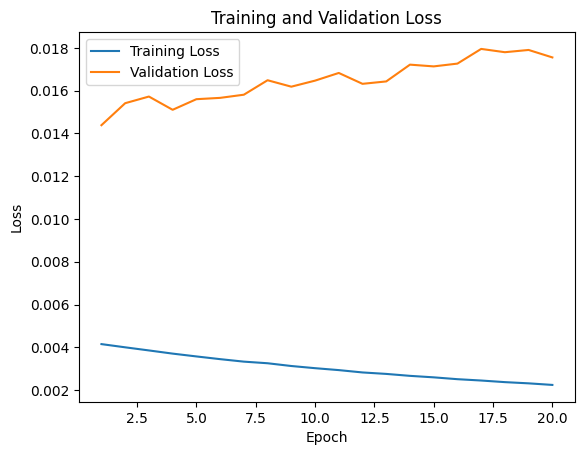

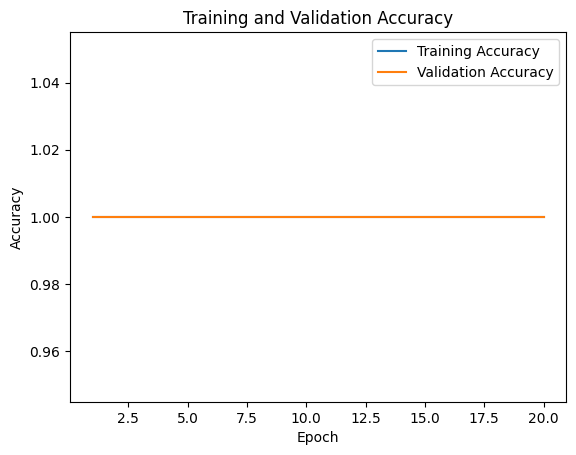

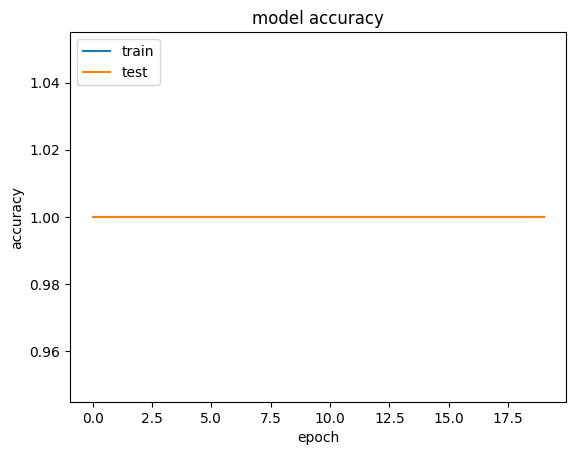

In [11]:
import matplotlib.pyplot as plt

# Get training and validation loss histories
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Get training and validation accuracy histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
epoch_range = range(1, len(training_loss) + 1)
plt.plot(epoch_range, training_loss, label='Training Loss')
plt.plot(epoch_range, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(epoch_range, training_accuracy, label='Training Accuracy')
plt.plot(epoch_range, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# plot epoch to accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
